In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
tqdm.pandas()

In [2]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [3]:
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""

# Reading the data

In [4]:
df = pd.read_csv('data/nyc_taxi_data.csv')

In [6]:
df.head()

,timestamp,passenger_count,trip_distance,total_amount,humidity,pressure,temperature,weather_description,wind_direction,wind_speed
0,1498050000,26805,45733.59,285315.95,57.0,1014.0,295.37,sky is clear,290.0,3.0
1,1486310400,27487,50781.62,262346.81,51.0,1016.0,273.91,overcast clouds,250.0,5.0
2,1464897600,41686,71816.81,400042.82,82.0,1020.0,296.72,haze,90.0,5.0
3,1456308000,31526,44498.25,291332.16,86.0,1019.0,275.77,mist,70.0,6.0
4,1458097200,4138,9353.05,42545.26,81.0,1010.0,282.52,overcast clouds,15.0,1.0


In [26]:
df.passenger_count.mean()

23102.56513314164

# Looking at the weather description

In [7]:
df.weather_description.value_counts()

sky is clear                           4288
mist                                   2524
broken clouds                          1973
scattered clouds                       1511
light rain                             1410
overcast clouds                        1388
few clouds                             1049
fog                                     514
haze                                    324
moderate rain                           253
light intensity drizzle                 203
light snow                              202
drizzle                                 135
proximity thunderstorm                   58
heavy intensity rain                     55
thunderstorm                             29
heavy snow                               17
thunderstorm with light rain             14
snow                                     11
thunderstorm with rain                    9
heavy intensity drizzle                   9
freezing rain                             5
thunderstorm with heavy rain    

The weather description shows that there are close cases and similar cases (like 'proximity thunderstorm with drizzle' and 'thunderstorm with light drizzle') may be using a word vector will be more appropriate than a simple one-hot encoding. 

## Checking for faulty records

In [8]:
df['denom'] = df.apply(lambda x: x['trip_distance']*x['passenger_count'], axis = 1)

In [9]:
faulty_rows = df[df.denom == 0.]

In [10]:
faulty_rows = faulty_rows.append(df[df['trip_distance']<=0.])

### Identify and remove NaN in the weather data

In [11]:
faulty_rows = faulty_rows.append(df[df.weather_description.isna()])

In [12]:
faulty_rows.head()

,timestamp,passenger_count,trip_distance,total_amount,humidity,pressure,temperature,weather_description,wind_direction,wind_speed,denom
1343,1042574400,1,0.0,2.3,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1816,978760800,1,0.0,3.8,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3867,978307200,1,0.0,3.8,NaN,NaN,NaN,NaN,NaN,NaN,0.0
10509,1042567200,1,0.0,2.3,NaN,NaN,NaN,NaN,NaN,NaN,0.0
12614,1516453200,1,0.0,6.3,NaN,NaN,NaN,NaN,NaN,NaN,0.0


There are faulty records on the data where there is no amount recorded and only one passenger with 0. distance

There is also one record with negative value for the trip distance, it could be faulty data entry. But better to ignore the value for now. 

There are also few more records with no weather data

In [13]:
df.drop(faulty_rows.index, axis = 0, inplace = True)

amount_rate is a measure to see what is the cost for one passenger for one mile of travel

In [14]:
df['amount_rate'] = df.apply(lambda x: x['total_amount']/(x['trip_distance']), axis = 1)

In [15]:
df['amount_rate'].describe()

count    15998.000000
mean         5.324596
std          0.935241
min          0.007764
25%          4.741654
50%          5.290961
75%          5.901528
max         32.933929
Name: amount_rate, dtype: float64

## Initially cleaned up records

In [15]:
df.head()

,timestamp,passenger_count,trip_distance,total_amount,humidity,pressure,temperature,weather_description,wind_direction,wind_speed,denom,amount_rate
0,1498050000,26805,45733.59,285315.95,57.0,1014.0,295.37,sky is clear,290.0,3.0,1.225889e+09,0.000233
1,1486310400,27487,50781.62,262346.81,51.0,1016.0,273.91,overcast clouds,250.0,5.0,1.395834e+09,0.000188
2,1464897600,41686,71816.81,400042.82,82.0,1020.0,296.72,haze,90.0,5.0,2.993756e+09,0.000134
3,1456308000,31526,44498.25,291332.16,86.0,1019.0,275.77,mist,70.0,6.0,1.402852e+09,0.000208
4,1458097200,4138,9353.05,42545.26,81.0,1010.0,282.52,overcast clouds,15.0,1.0,3.870292e+07,0.001099


## Translating timestamp to a datetime for training

In [16]:
df['time'] = df.timestamp.apply(lambda x: datetime.fromtimestamp(x))

# Encoding the weather description into spacy vectors

In [20]:
def get_spacy_vec(text):
    doc = nlp(text)
    return doc.vector/doc.vector_norm

In [22]:
df_spacy = df.copy()
df_spacy['weather_vec'] = df_spacy['weather_description'].progress_apply(get_spacy_vec)

100%|██████████| 15998/15998 [02:59<00:00, 89.26it/s] 


# Encoding the weather description with LabelEncoder

In [23]:
df['weather_description'] = LabelEncoder().fit_transform(df['weather_description'])

# Data Visualizations

## Time series plots for different variables

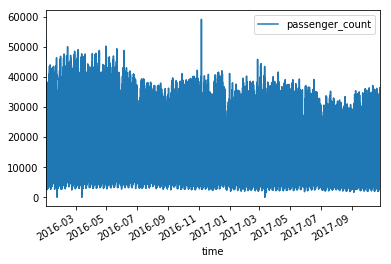

In [24]:
df.plot('time', 'passenger_count')

plotting for a smaller time frame 01/05/2017 - 01/07/2017 as a sample

(736450.0, 736511.0)

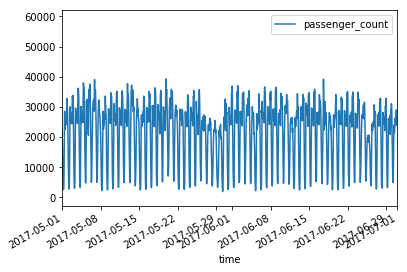

In [25]:
df.plot('time', 'passenger_count')
plt.xlim([datetime(2017,5,1),datetime(2017,7,1)])

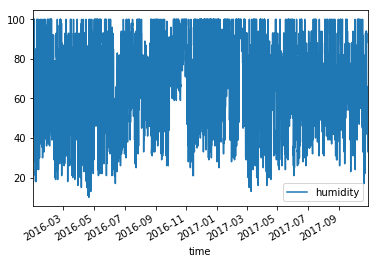

In [26]:
df.plot('time', 'humidity')

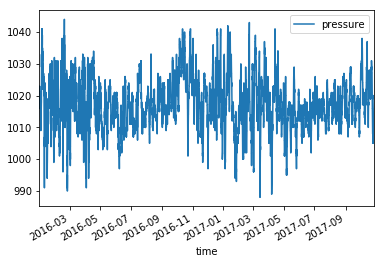

In [27]:
df.plot('time','pressure')

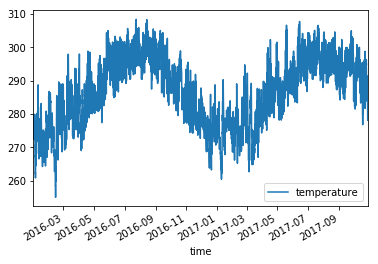

In [28]:
df.plot('time', 'temperature')

We can clearly see the seasonal pattern above

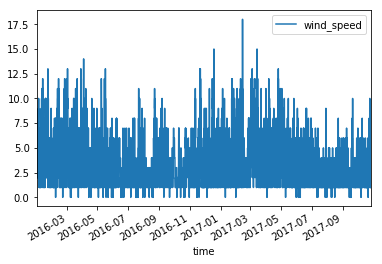

In [29]:
df.plot('time', 'wind_speed')

## Visualising the dependencies of the features with the passenger count

(0, 100000)

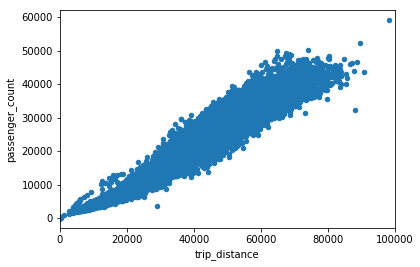

In [30]:
df.plot.scatter('trip_distance','passenger_count')
plt.xlim([0,100000])

(0, 10000)

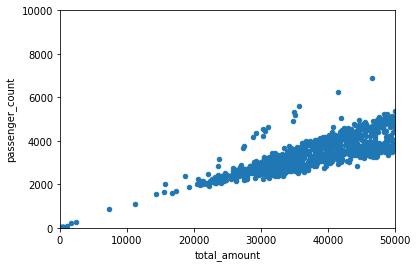

In [31]:
df.plot.scatter('total_amount','passenger_count')
plt.xlim([0,50000])
plt.ylim([0,10000])

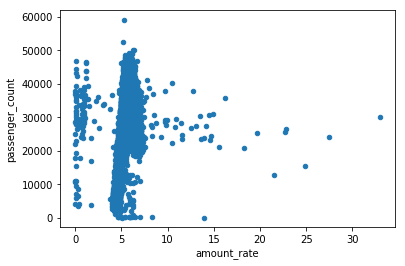

In [18]:
df.plot.scatter('amount_rate', 'passenger_count')
#plt.xlim([0,0.1])

## Aggregating and plotting dependencies

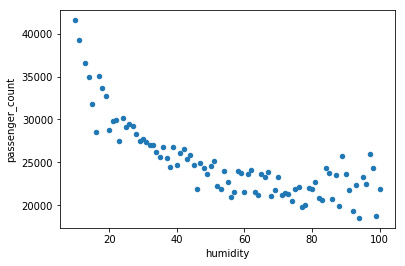

In [21]:
df_humidity = df.groupby('humidity').agg({'passenger_count':'mean'}).reset_index()
df_humidity.plot.scatter('humidity', 'passenger_count')

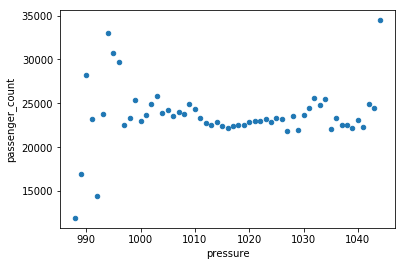

In [19]:
df_pressure = df.groupby('pressure').agg({'passenger_count':'mean'}).reset_index()
df_pressure.plot.scatter('pressure', 'passenger_count')

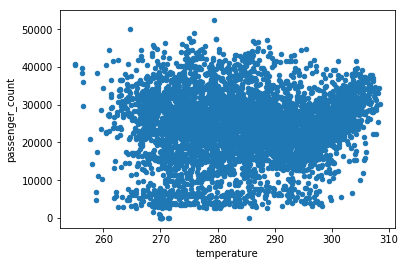

In [20]:
#df.plot.scatter('temperature', 'passenger_count')
df_temp = df.groupby('temperature').agg({'passenger_count':'mean'}).reset_index()
df_temp.plot.scatter('temperature', 'passenger_count')

In [22]:
df_wind = df.groupby(['wind_direction', 'wind_speed']).agg({'passenger_count':'mean'}).reset_index()

In [37]:
df_wind['wind_direction'] = df_wind['wind_direction'].apply(lambda x: np.deg2rad(x))

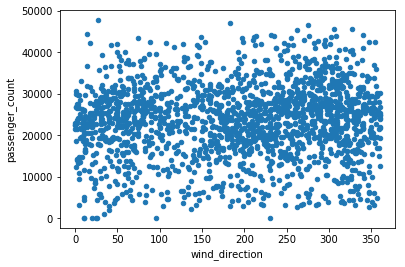

In [23]:
df_wind.plot.scatter('wind_direction', 'passenger_count')

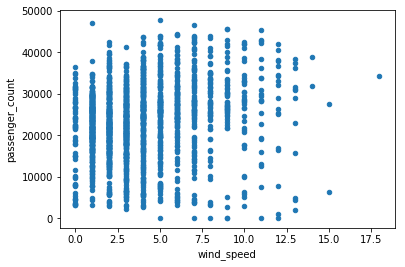

In [24]:
df_wind.plot.scatter('wind_speed', 'passenger_count')

# Saving cleaned up data and the faulty data for training

In [40]:
df.drop('denom', axis = 1).to_csv('data/cleaned_data.csv', index = False)

In [41]:
faulty_rows.drop(['denom'], axis = 1).to_csv('data/faulty_records.csv', index = False)

In [42]:
df_spacy.drop('denom', axis = 1).to_pickle('data/cleaned_data_spacy.p')